In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

import cv2
import itertools
import pathlib
import warnings
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from keras import layers
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from distutils.dir_util import copy_tree, remove_tree

import os
print(os.listdir("/content/drive/MyDrive/MajorProject/Dataset"))

print("TensorFlow Version:", tf.__version__)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
TensorFlow Version: 2.11.0


In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/MajorProject/Dataset', output="output", seed=1345, ratio=(.8, 0.1,0.1))

Copying files: 6450 files [02:52, 37.45 files/s] 


In [ ]:
import shutil

In [ ]:
source = '/content/output'
destination = '/content/drive/MyDrive/MajorProject'

In [ ]:
dest = shutil.move(source, destination)

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/MajorProject/output/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/MajorProject/output/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/MajorProject/output/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 5159 files belonging to 4 classes.
Found 647 files belonging to 4 classes.
Found 644 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

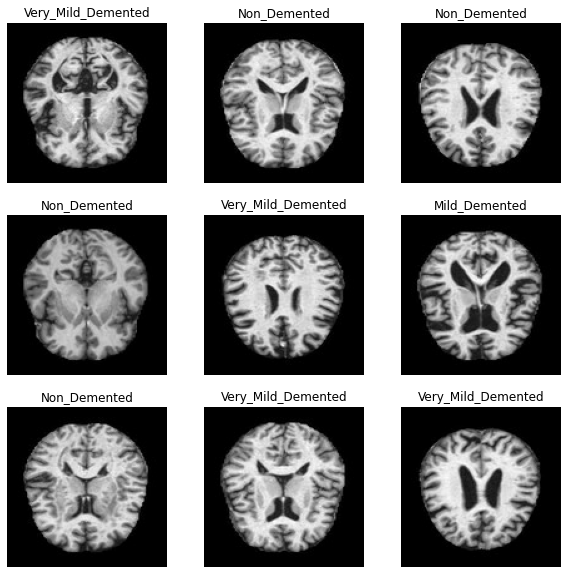

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<function matplotlib.pyplot.show(*args, **kw)>

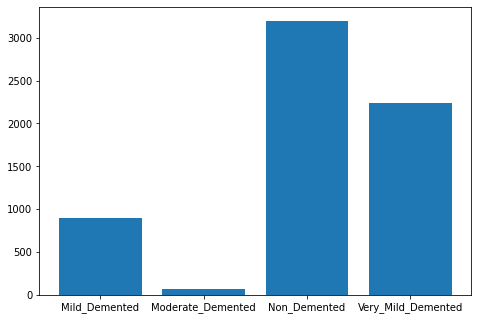

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
ax.bar(class_names,size)
plt.show

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

# create a TensorBoard callback
log_dir = 'logs/'
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)       

In [ ]:
hist = model.fit(train_ds,validation_data=val_ds,epochs=1, batch_size=64, verbose=1, callbacks=[tb_callback])

81/81 [==============================] - 608s 7s/step - loss: 1.3905 - accuracy: 0.4815 - val_loss: 1.0538 - val_accuracy: 0.4984


In [ ]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

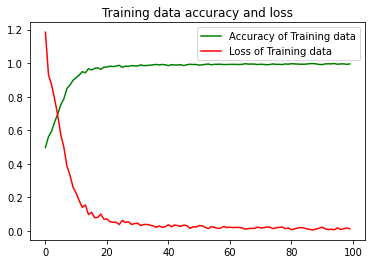

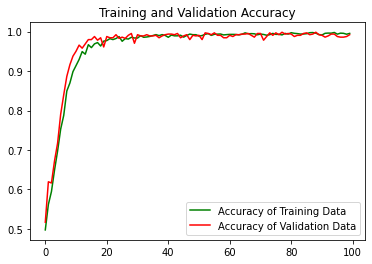

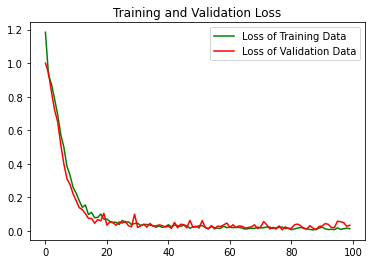

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)

11/11 [==============================] - 1s 50ms/step - loss: 0.0272 - accuracy: 0.9938


1/1 [==============================] - 0s 44ms/step


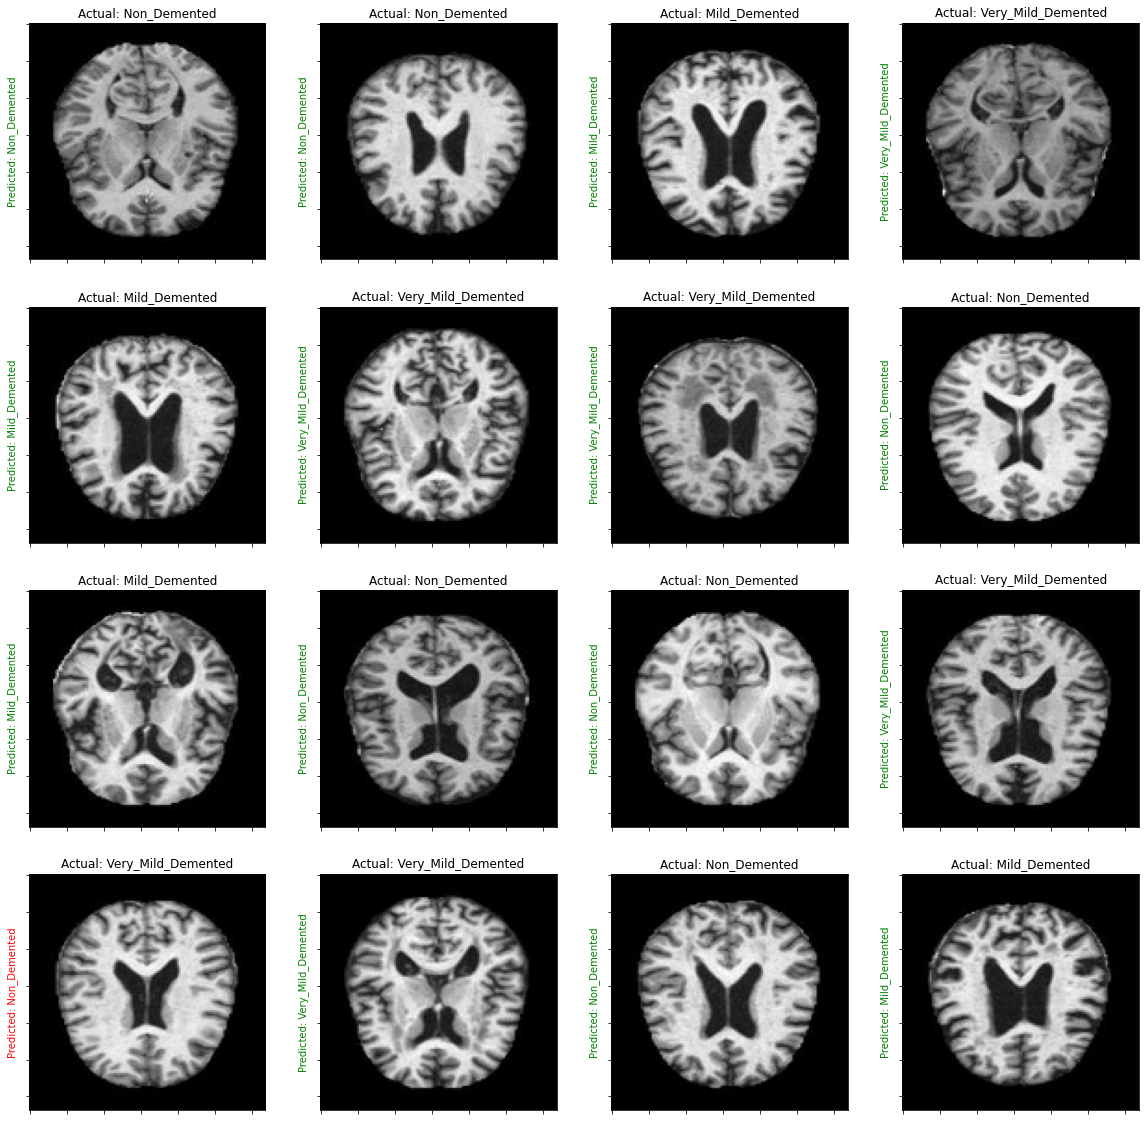

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})

        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])


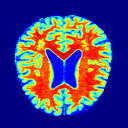

-1

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread('/content/drive/MyDrive/MajorProject/Dataset/Mild_Demented/mild_10.jpg', 0)
heatmap = cv2.applyColorMap(image, cv2.COLORMAP_JET)

cv2_imshow( heatmap)
cv2.waitKey()

#Part-2


In [ ]:
import cv2

import os,glob

from os import listdir,makedirs

from os.path import isfile,join
path = '/content/drive/MyDrive/MajorProject/output/val/Very_Mild_Demented' # Source Folder
dstpath = '/content/drive/MyDrive/MajorProject/output1/val/Ver_Mild_Demented' # Destination Folder
try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in same folder")
# Folder won't used
files = list(filter(lambda f: isfile(join(path,f)), listdir(path)))
for image in files:
    try:
        img = cv2.imread(os.path.join(path,image))
        # gray = cv2.cvtColor(img,cv2.COLORMAP_JET)
        heatmap = cv2.applyColorMap(img, cv2.COLORMAP_JET)
        dstPath = join(dstpath,image)
        cv2.imwrite(dstPath,heatmap)
    except:
        print ("{} is not converted".format(image))
for fil in glob.glob("*.jpg"):
    try:
        image = cv2.imread(fil)
        heatmap_image = cv2.applyColorMap(os.path.join(path,image), cv2.COLORMAP_JET)
        # gray_image = cv2.cvtColor(os.path.join(path,image), cv2.COLOR_BGR2GRAY) # convert to greyscale
        cv2.imwrite(os.path.join(dstpath,fil),heatmap_image)
    except:
        print('{} is not converted')

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/MajorProject/output1/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/MajorProject/output1/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/MajorProject/output1/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 5159 files belonging to 4 classes.
Found 647 files belonging to 4 classes.
Found 644 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

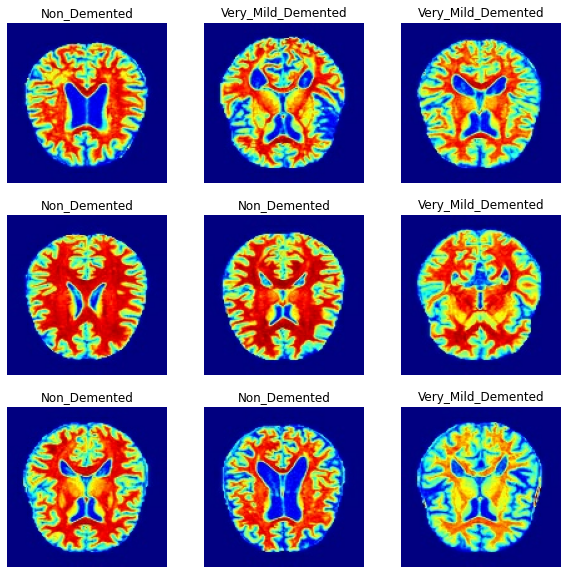

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [ ]:
hist = model.fit(train_ds,validation_data=val_ds,epochs=100, batch_size=64, verbose=1)

Epoch 1/100
81/81 [==============================] - 1016s 13s/step - loss: 1.3985 - accuracy: 0.4712 - val_loss: 1.1221 - val_accuracy: 0.5124
Epoch 2/100
81/81 [==============================] - 9s 100ms/step - loss: 0.9400 - accuracy: 0.5406 - val_loss: 1.0531 - val_accuracy: 0.5248
Epoch 3/100
81/81 [==============================] - 8s 89ms/step - loss: 0.8688 - accuracy: 0.5833 - val_loss: 0.9018 - val_accuracy: 0.6165
Epoch 4/100
81/81 [==============================] - 9s 97ms/step - loss: 0.8097 - accuracy: 0.6193 - val_loss: 0.7963 - val_accuracy: 0.6475
Epoch 5/100
81/81 [==============================] - 9s 100ms/step - loss: 0.7406 - accuracy: 0.6505 - val_loss: 0.7244 - val_accuracy: 0.6972
Epoch 6/100
81/81 [==============================] - 8s 90ms/step - loss: 0.7007 - accuracy: 0.6887 - val_loss: 0.6382 - val_accuracy: 0.7220
Epoch 7/100
81/81 [==============================] - 9s 101ms/step - loss: 0.6265 - accuracy: 0.7213 - val_loss: 0.5786 - val_accuracy: 0.7717
E

In [ ]:
loss, accuracy = model.evaluate(test_ds)

11/11 [==============================] - 203s 2s/step - loss: 0.0253 - accuracy: 0.9892


In [ ]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

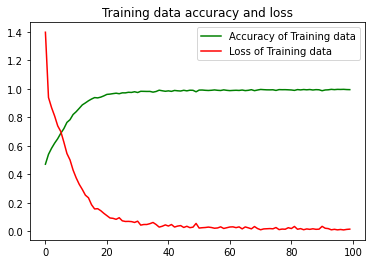

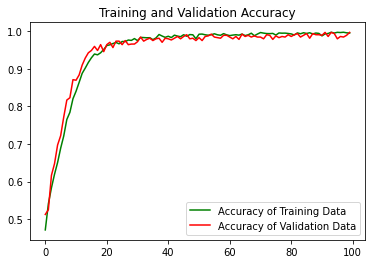

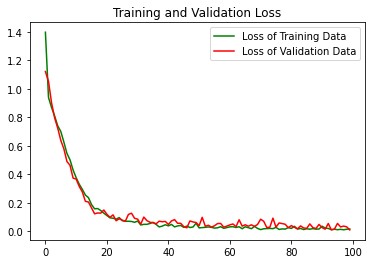

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

1/1 [==============================] - 0s 23ms/step


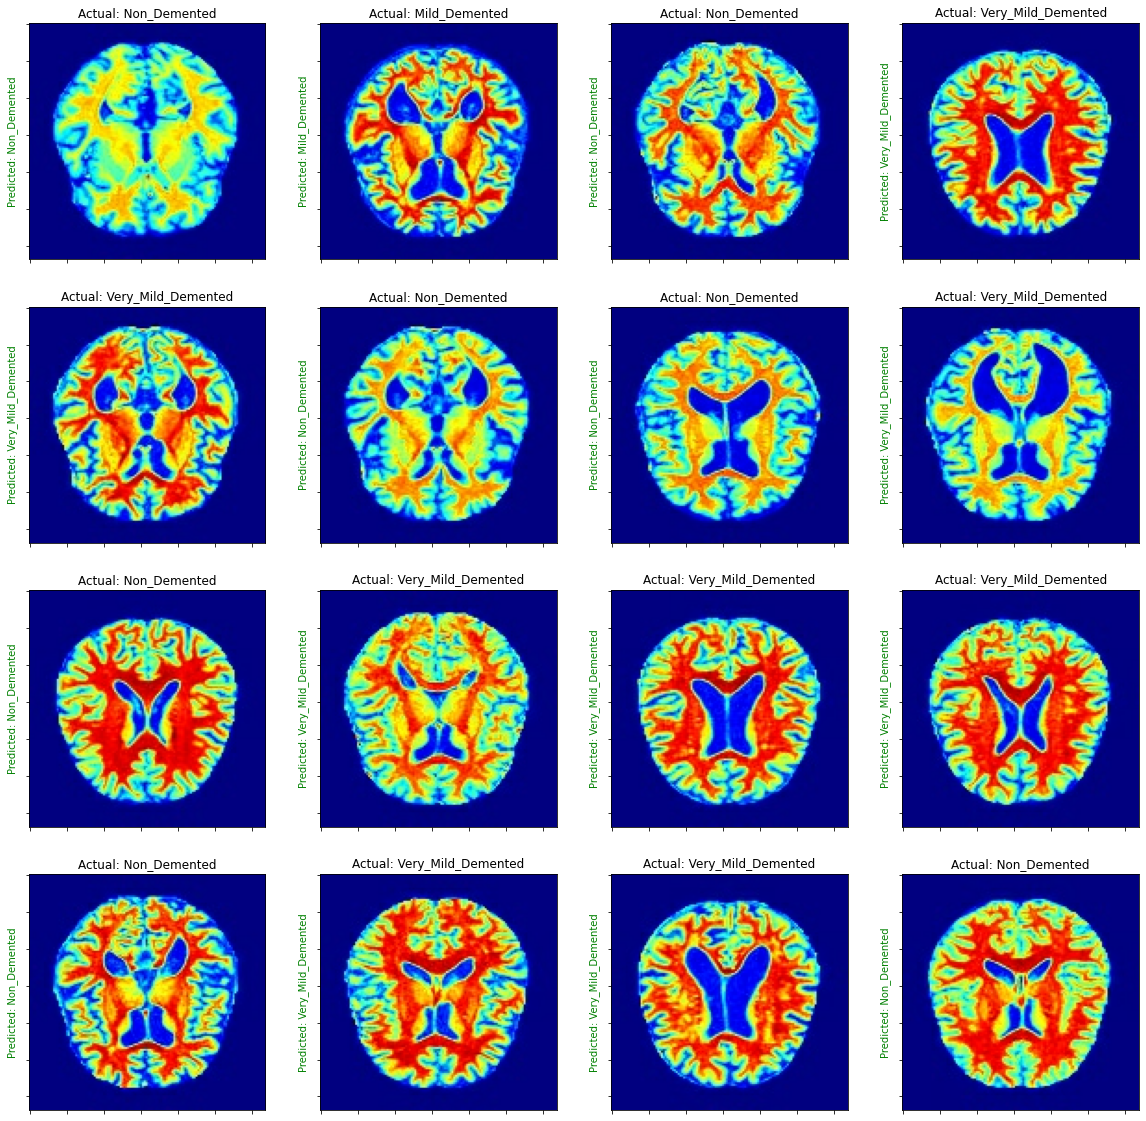

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})

        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])


In [ ]:
import tensorflow as tf

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from skimage.io import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense,Conv2D,Flatten

In [ ]:
tf.__version__

'2.11.0'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         rotation_range=20,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         width_shift_range=0.2,
#         height_shift_range=0.2)

# test_datagen = ImageDataGenerator(rescale=1./255)

IMG_HEIGHT = 128
IMG_WIDTH = 128

# train_ds = train_datagen.flow_from_directory(
#         "/content/drive/MyDrive/MajorProject/output/train",
#         target_size=(IMG_HEIGHT, IMG_WIDTH),
#         batch_size=64,
#         class_mode='sparse')


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/MajorProject/output/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/MajorProject/output/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/MajorProject/output/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 5159 files belonging to 4 classes.
Found 647 files belonging to 4 classes.
Found 644 files belonging to 4 classes.


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization


In [ ]:
# IMPOSING IMAGE DIMENSIONS AND RESTRICTIONS
IMG_HEIGHT = 224
IMG_WIDTH = 224


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/MajorProject/output1/train",
seed=None,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/MajorProject/output1/test",
seed=None,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/MajorProject/output1/val",
seed=None,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 5159 files belonging to 4 classes.
Found 647 files belonging to 4 classes.
Found 644 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)
len(class_names)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


4

In [ ]:
# IMPORTING LIBRARIES
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

In [ ]:
# IMPORTNG THE BASE EFFICIENTNET MODEL
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis = -1, momentum= 0.99, epsilon= 0.001),
    Dropout(rate= 0.45),
    Flatten(),
    Dense(512, activation= 'relu'),
    Dense(4, activation= 'softmax')
])

model.compile(Adam(learning_rate= 0.001), loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 module_wrapper (ModuleWrapp  (None, 1280)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 1280)             0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 512)              655872    
 pper)                                                  

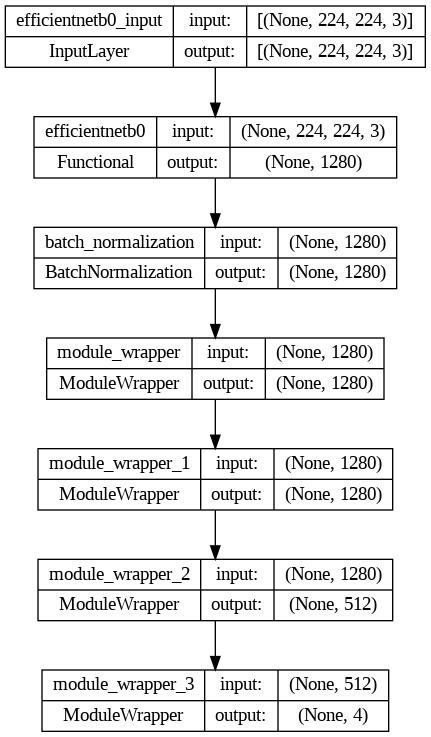

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# RUNNING THE MODEL
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
effnet_history = model.fit(train_ds, epochs= 100,
                    validation_data= val_ds, callbacks = [callback])

Epoch 1/100
81/81 [==============================] - 1101s 12s/step - loss: 1.2548 - accuracy: 0.5468 - val_loss: 1.1774 - val_accuracy: 0.5683
Epoch 2/100
81/81 [==============================] - 48s 572ms/step - loss: 0.6335 - accuracy: 0.7333 - val_loss: 1.1348 - val_accuracy: 0.6661
Epoch 3/100
81/81 [==============================] - 47s 569ms/step - loss: 0.4619 - accuracy: 0.8250 - val_loss: 1.0775 - val_accuracy: 0.7733
Epoch 4/100
81/81 [==============================] - 47s 566ms/step - loss: 0.2262 - accuracy: 0.9141 - val_loss: 0.4247 - val_accuracy: 0.8696
Epoch 5/100
81/81 [==============================] - 46s 558ms/step - loss: 0.1209 - accuracy: 0.9570 - val_loss: 0.2969 - val_accuracy: 0.9301
Epoch 6/100
81/81 [==============================] - 46s 559ms/step - loss: 0.1081 - accuracy: 0.9647 - val_loss: 0.3302 - val_accuracy: 0.9053
Epoch 7/100
81/81 [==============================] - 47s 560ms/step - loss: 0.0595 - accuracy: 0.9800 - val_loss: 0.1820 - val_accuracy:

In [ ]:
# TESTING THE ACCURACY ON THE TEST SET
loss, accuracy = model.evaluate(test_ds)

11/11 [==============================] - 151s 2s/step - loss: 0.1837 - accuracy: 0.9382


In [ ]:
98.45, 93.66
BN- 97.99
bn, d256
fl 98.76

In [ ]:
# PLOTTING THE GRAPHS
get_ac = effnet_history.history['accuracy']
get_los = effnet_history.history['loss']
val_acc = effnet_history.history['val_accuracy']
val_loss = effnet_history.history['val_loss']

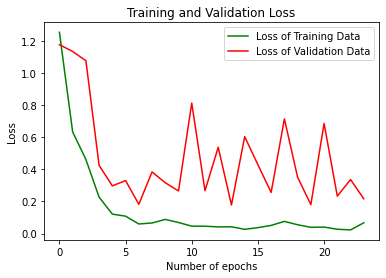

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.figure()
plt.show()